# Lab 5:  RC Circuit Analysis

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

# Capacitor-Resistor Combination 1

In each phase of this experiment, a different combination of capactior and resistor, in a series circuit, was used.  The theory is as follows:

When the switch is closed, thus defining $t=0$, the voltage across the capacitor will be given by:

$
\begin{equation}
V(t) = V_{source}(1 - e^{-\frac{t}{RC}})
\end{equation}
$

The current through the circuit, defined according to $i_C = C\frac{dV_C}{dt}$, is:

$
\begin{equation}
i(t) = \frac{V_{source}}{R}e^{-\frac{t}{RC}}
\end{equation}
$

The charge on the capacitor, defined by $Q = \int_0^t i(t)dt$, is given by:

$
\begin{equation}
Q(t) = C V_{source}(1-e^{-\frac{t}{RC}})
\end{equation}
$


In [78]:
# Create a Pandas DataFrame with data for part 1

df1 = pd.read_csv("exp5_data_part1.csv")

df1_iv = (df1.copy()).drop(df1.columns[3], axis=1).dropna()
df1_q = (df1.copy()).drop(df1.columns[2], axis=1)
df1_q = (df1_q.copy()).drop(df1_q.columns[1], axis=1).dropna()

In [79]:
df1_iv = df1_iv.set_axis(['t', 'v', 'i'], axis=1, inplace=False)
df1_q = df1_q.set_axis(['t', 'q'], axis=1, inplace=False)

df1_iv['di']=0.000001
df1_iv['dv']=0.001
df1_iv['dt']=0.0001

df1_q['dt']=0.0001
df1_q['dq']=1E-8

df1_iv

,t,v,i,di,dv,dt
0,0.0000,-0.004,0.000109,0.000001,0.001,0.0001
2,0.0005,-0.004,0.000068,0.000001,0.001,0.0001
4,0.0010,-0.002,0.000083,0.000001,0.001,0.0001
6,0.0020,-0.003,0.000073,0.000001,0.001,0.0001
8,0.0020,-0.004,0.000082,0.000001,0.001,0.0001
...,...,...,...,...,...,...
37360,9.3400,9.820,0.000256,0.000001,0.001,0.0001
37362,9.3410,9.820,0.000235,0.000001,0.001,0.0001
37364,9.3410,9.819,0.000242,0.000001,0.001,0.0001
37366,9.3420,9.819,0.000214,0.000001,0.001,0.0001


Our first task is to define the $t=0$ point.  We should graph the raw data, for voltage vs. time, and use this plot to decide on the fit region.

<ErrorbarContainer object of 3 artists>

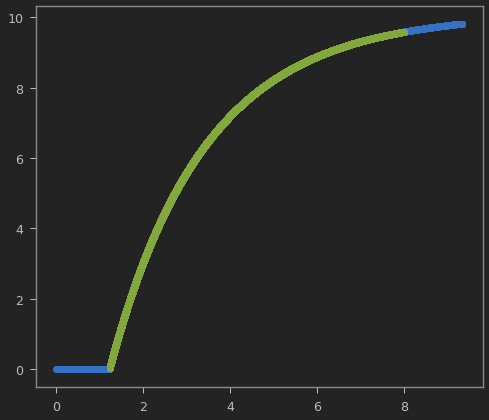

In [64]:
xi = df1_iv['t']
yi = df1_iv['v']
sigmaxi = df1_iv['dt']
sigmayi = df1_iv['dv']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)
#plt.xlim(1.2,1.23)
#plt.ylim(-0.025,0.025)

tlow = 1.220
thigh = 8.000

df1_iv_select = df1_iv[(df1_iv['t']>tlow) & (df1_iv['t']<thigh)]
xi = df1_iv_select['t']
yi = df1_iv_select['v']
sigmaxi = df1_iv_select['dt']
sigmayi = df1_iv_select['dv']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)



Beta: [10.02936758  1.20385944  2.20256167]
Beta Std Error: [3.38644298e-04 9.05950943e-05 2.51418360e-04]
Beta Covariance: [[ 9.83240909e-10 -1.32561698e-10  6.57763066e-10]
 [-1.32561698e-10  7.03690626e-11 -1.42108344e-10]
 [ 6.57763066e-10 -1.42108344e-10  5.41958939e-10]]
Residual Variance: 116.63465156342538
Inverse Condition #: 0.10842247956292501
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (10.029367580 +/- 0.000338644) (1 - EXP(-(X - (1.203859445 +/- 0.000090595))/(2.202561666 +/- 0.000251418)))


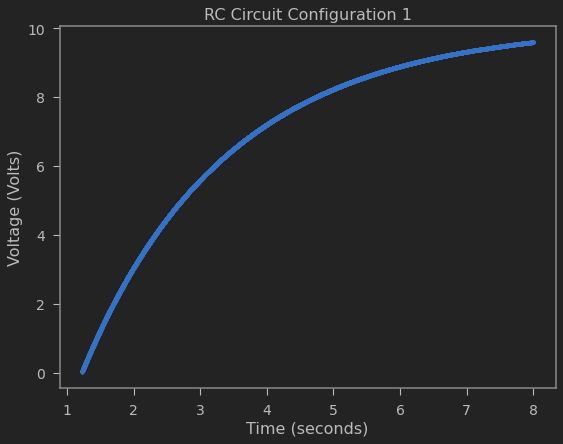

In [71]:
from scipy.odr import *

def fitfunction(B, x):
    '''Exponential function y = B[0](1 - e^(-(x-B[1])/B[2]))'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*(1.0-np.exp(-(x-B[1])/B[2]))

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[10.0, tlow, 5.]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) (1 - EXP(-(X - (%0.9f +/- %0.9f))/(%0.9f +/- %0.9f)))" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='.', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (Volts)')
plt.title('RC Circuit Configuration 1')
plt.show()

<ErrorbarContainer object of 3 artists>

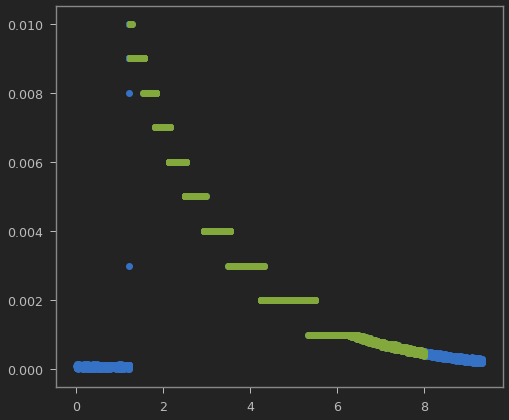

In [75]:
xi = df1_iv['t']
yi = df1_iv['i']
sigmaxi = df1_iv['dt']
sigmayi = df1_iv['di']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)
#plt.xlim(1.2,1.23)
#plt.ylim(-0.025,0.025)

tlow = 1.220
thigh = 8.000

df1_iv_select = df1_iv[(df1_iv['t']>tlow) & (df1_iv['t']<thigh)]
xi = df1_iv_select['t']
yi = df1_iv_select['i']
sigmaxi = df1_iv_select['dt']
sigmayi = df1_iv_select['di']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

Beta: [0.01040944 1.08274671 2.22665668]
Beta Std Error: [7.76053658e+01 1.66003717e+04 2.60904395e-03]
Beta Covariance: [[ 9.79519848e-02 -2.09526666e+01  6.00681359e-07]
 [-2.09526666e+01  4.48193306e+03 -1.28490324e-04]
 [ 6.00681359e-07 -1.28490324e-04  1.10711448e-10]]
Residual Variance: 61485.15324675486
Inverse Condition #: 2.5004042448937048e-08
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (0.010409436 +/- 77.605365787) (EXP(-(X - (1.082746707 +/- 16600.371708141))/(2.226656679 +/- 0.002609044)))


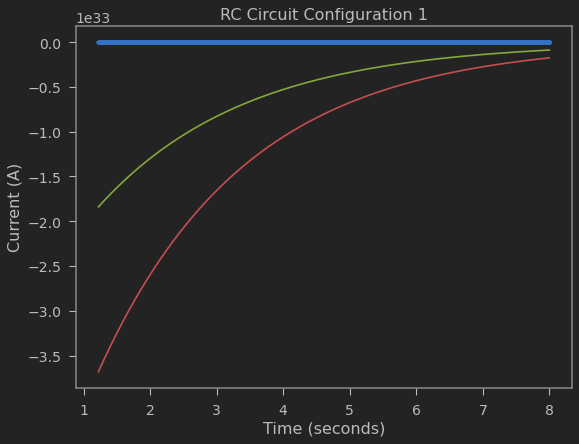

In [77]:
from scipy.odr import *

def fitfunction(B, x):
    '''Exponential function y = B[0](e^(-(x-B[1])/B[2]))'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*(np.exp(-(x-B[1])/B[2]))

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[0.01, tlow, 2.2]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) (EXP(-(X - (%0.9f +/- %0.9f))/(%0.9f +/- %0.9f)))" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='.', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Time (seconds)')
plt.ylabel('Current (A)')
plt.title('RC Circuit Configuration 1')
plt.show()